# How to Train Your Own Key Points Detection Networks

![](https://user-images.githubusercontent.com/22118253/69765965-fd65a700-1143-11ea-8804-cd1d33f2e824.png)

In this notebook, we will demonstrate 
- how to train your own KeyPoints detection network and do inference on pictures of traffic cone.

**[Accurate Low Latency Visual Perception for Autonomous Racing: Challenges Mechanisms and Practical Solutions](https://github.com/mit-han-lab/once-for-all)** is an accurate low latency visual perception system introduced by Kieran Strobel, Sibo Zhu, Raphael Chang, and Skanda Koppula.


## 1. Preparation
Let's first install all the required packages:

In [2]:
# ! conda install --yes --prefix {sys.prefix} unzip
# ! sudo apt install unzip
print('Installing numpy...')
! pip3 install numpy 
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip3 install tqdm 
print('Installing matplotlib...')
! pip3 install matplotlib 
print('Installing dataset reader...')
! pip3 install pandas

Installing numpy...
Installing tqdm (progress bar) ...
Installing matplotlib...
Installing dataset reader...


In [1]:
import cv2

In [4]:
# conda install -c conda-forge google-cloud-sdk

Solving environment: done

## Package Plan ##

  environment location: /Users/mario/opt/anaconda3

  added / updated specs:
    - google-cloud-sdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    google-cloud-sdk-385.0.0   |   py39h6e9494a_0       107.5 MB  conda-forge
    ------------------------------------------------------------
                                           Total:       107.5 MB

The following NEW packages will be INSTALLED:

  google-cloud-sdk   conda-forge/osx-64::google-cloud-sdk-385.0.0-py39h6e9494a_0



google-cloud-sdk-385 | 107.5 MB  | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
# conda install -c conda-forge google-cloud-storage

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /Users/mario/opt/anaconda3

  added / updated specs:
    - google-cloud-storage


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cachetools-4.2.4           |     pyhd8ed1ab_0          12 KB  conda-forge
    google-api-core-1.27.0     |     pyhd8ed1ab_0          59 KB  conda-forge
    google-auth-1.21.3         |             py_0          56 KB  conda-forge
    google-cloud-core-1.5.0    |     pyhd3deb0d_0          26 KB  conda-forge
    google-cloud-storage-1.38.0|     pyh44b312d_0          71 KB  conda-forge
    google-crc32c-1.1.2        |   py39hb687f8d_3          22 KB  conda-forge
    google-resumable-media-1.3.3|     pyh6

In [3]:
from google.cloud import storage

Let' s clone our repo first...

In [2]:
# ! git clone https://github.com/cv-core/MIT-Driverless-CV-TrainingInfra.git

# ! mv MIT-Driverless-CV-TrainingInfra/RektNet/* .

Cloning into 'MIT-Driverless-CV-TrainingInfra'...
remote: Enumerating objects: 834, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 834 (delta 147), reused 111 (delta 57), pack-reused 620
Receiving objects: 100% (834/834), 9.65 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (537/537), done.


Before we start training, let's download the Cone Detection dataset and the corresponding label and intial training weights. 

In [ ]:
# print("Downloading Training Dataset")
# ! wget https://storage.googleapis.com/mit-driverless-open-source/RektNet_Dataset.zip
# ! unzip -q RektNet_Dataset.zip
# ! mv RektNet_Dataset dataset/ && rm RektNet_Dataset.zip
# print("Downloading Training and Validation Label")
# ! cd dataset/ && wget https://storage.googleapis.com/mit-driverless-open-source/rektnet-training/mini_rektnet_label.csv && mv mini_rektnet_label.csv rektnet_label.csv && cd ..

In [3]:
print("Downloading Training Dataset")
# ! gsutil cp -p gs://mit-driverless-open-source/RektNet_Dataset.zip ./dataset/
# ! unzip dataset/RektNet_Dataset.zip -d ./dataset/
# ! rm RektNet_Dataset.zip

print("Downloading Training and Validation Label")
# ! gsutil cp -p gs://mit-driverless-open-source/rektnet-training/mini_rektnet_label.csv ./dataset/
# ! gsutil cp -p gs://mit-driverless-open-source/rektnet-training/rektnet_label.csv ./dataset/

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/RektNet_Dataset/vid_40_frame_259_23.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_31_frame_1950_3.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_28_frame_1930_4.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_31_frame_2533_7.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_71_frame_45_4.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_30_frame_1501_0.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_5_frame_2497_12.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_101_frame_222_18.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_42_frame_840_3.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_5_frame_2347_0.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_40_frame_266_9.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_42_frame_535_6.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_38_frame_775_4.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_2_frame_26331_2.jpg  
  inflating: ./dataset/RektNet_Dataset/vid_30

## 2. Training


First, import all the packages used in this tutorial:

In [4]:
import argparse
import tempfile
import sys
import os
import multiprocessing
import shutil
from tqdm import tqdm
import numpy as np
import cv2
import copy
from datetime import datetime
from tqdm import tqdm

import PIL
from PIL import Image, ImageDraw

import torch
from torch.autograd import Variable
from torch.backends import cudnn
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

from keypoint_net import KeypointNet
from cross_ratio_loss import CrossRatioLoss
from utils import Logger
from utils import load_train_csv_dataset, prep_image, visualize_data, vis_tensor_and_save, calculate_distance, calculate_mean_distance
from dataset import ConeDataset
from keypoint_tutorial_util import print_tensor_stats, eval_model, print_kpt_L2_distance

cv2.setRNGSeed(2)
torch.manual_seed(2)
np.random.seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

visualization_tmp_path = "/outputs/visualization/"

Successfully imported all packages and configured random seed to 17!

Training Config

In [5]:
study_name="tutorial"

current_month = datetime.now().strftime('%B').lower()
current_year = str(datetime.now().year)
if not os.path.exists(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')):
    os.makedirs(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/'))
output_uri = os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')

save_file_name = 'logs/' + output_uri.split('/')[-2]
sys.stdout = Logger(save_file_name + '.log')
sys.stderr = Logger(save_file_name + '.error')

# Training related config
INPUT_SIZE = (80, 80) # dataset size
KPT_KEYS = ["top", "mid_L_top", "mid_R_top", "mid_L_bot", "mid_R_bot", "bot_L", "bot_R"] # set up geometry loss keys
intervals = int(2) # for normal training, set it to 4
val_split = float(0.15) # training validation split ratio
batch_size= int(8)
num_epochs= int(4) # for normal training, set it to 1024
train_csv = "dataset/rektnet_label.csv"
dataset_path = "dataset/RektNet_Dataset/"
vis_dataloader = False # visualize dataset
save_checkpoints = True

# Training related hyperparameter
lr = 1e-1
lr_gamma = 0.999
geo_loss = True
geo_loss_gamma_vert = 0
geo_loss_gamma_horz = 0
loss_type = "l1_softargmax" # loss function type: l2_softargmax|l2_heatmap|l1_softargmax
best_val_loss = float('inf')
best_epoch = 0
max_tolerance = 8
tolerance = 0
num_kpt=len(KPT_KEYS)

Including geometric loss: True
Loss type: l1_softargmax


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying gs://mit-driverless-open-source/test_kpt.png...
AccessDeniedException: 403 HttpError accessing <https://storage.googleapis.com/download/storage/v1/b/mit-driverless-open-source/o/test_kpt.png?generation=1598334988006588&alt=media>: response: <{'x-guploader-uploadid': 'ADPycdsmhO82Hs4f1eFoDS1mtrKS6v9gO1tAsU6CNNgin_VRdSmNxxIqow15aNGbvCg6mCsSQkV_6SeDTdz6_ZISITN_tA', 'content-type': 'text/html; charset=UTF-8', 'date': 'Tue, 17 May 2022 12:03:42 GMT', 'vary': 'Origin, X-Origin', 'expires': 'Tue, 17 May 2022 12:03:42 GMT', 'cache-control': 'private, max-age=0', 'content-length': '70', 'server': 'UploadServer', 'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"', 'status': '403'}>, content

[ WARN:0@299.660] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('test_kpt.png'): can't open/read file: check file path/integrity


Copying gs://mit-driverless-open-source/test_kpt.png...
AccessDeniedException: 403 HttpError accessing <https://storage.googleapis.com/download/storage/v1/b/mit-driverless-open-source/o/test_kpt.png?generation=1598334988006588&alt=media>: response: <{'x-guploader-uploadid': 'ADPycdvZr19P1T8kF8vhWuhb_3dI54zppgs5rZ-MVcDlTAVPX63iULur6ioFxFUbRNeBFEldzdL39ZnnmwqO01vlpYq0eLJWlXhZ', 'content-type': 'text/html; charset=UTF-8', 'date': 'Tue, 17 May 2022 12:07:03 GMT', 'vary': 'Origin, X-Origin', 'expires': 'Tue, 17 May 2022 12:07:03 GMT', 'cache-control': 'private, max-age=0', 'content-length': '70', 'server': 'UploadServer', 'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"', 'status': '403'}>, content <The billing account for the owning project is disabled in state absent>
Copying gs://mit-driverless-open-source/test_kpt.png...
AccessDeniedException: 403 HttpError acces

[ WARN:0@1131.454] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('vid_2_frame_1877_1.png'): can't open/read file: check file path/integrity
[ WARN:0@1138.827] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('vid_2_frame_1877_1.png'): can't open/read file: check file path/integrity
[ WARN:0@1155.223] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('dataset/vid_2_frame_1877_1.png'): can't open/read file: check file path/integrity
[ WARN:0@1161.539] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./dataset/vid_2_frame_1877_1.png'): can't open/read file: check file path/integrity
[ WARN:0@1186.327] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (23

Caches do not exist!


Processing Image Dataset: 100%|##########| 3197/3197 [00:00<00:00, 3806.26it/s]


Saving cache...
./gs/03083f6f8ab6011e5825cf091cb9f452ad56af70975455445b42e72c323f8de2/images.npy ./gs/03083f6f8ab6011e5825cf091cb9f452ad56af70975455445b42e72c323f8de2/labels.npy
training image number: 2718
validation image number: 479
30 42
[2.166519, 6.5619535, 7.0313916, 10.796739, 13.376668, 25.255655, 20.923866]
37 61
[8.6505785, 4.098932, 7.6325135, 5.1582484, 7.8299723, 8.568755, 4.988735]
27 41
[9.066227, 8.421015, 9.013168, 1.4208168, 3.0859113, 14.929626, 8.624822]
20 26
[8.487347, 3.4112318, 17.379463, 4.9494276, 6.5034547, 12.972614, 5.7064204]
33 48
[9.524382, 9.457578, 7.709005, 18.643688, 19.177555, 37.408894, 18.229486]
27 39
[14.419802, 14.142762, 3.1933303, 3.1564164, 8.201193, 9.010102, 9.384758]
29 44
[10.9958105, 5.2437434, 5.264906, 2.9785852, 12.078969, 6.844108, 10.34645]
33 46
[6.500394, 8.15473, 3.3063247, 14.511805, 16.22098, 30.129156, 8.398425]
59 73
[3.9919126, 2.1688342, 5.852378, 6.0123153, 7.52594, 6.897335, 3.9162593]
30 36
[7.0221343, 9.152986, 9.15296

48 62
[1.7804201, 2.959673, 6.5927873, 6.616608, 5.99511, 7.0440183, 4.82824]
34 48
[12.657281, 20.73809, 10.163716, 23.600285, 9.37747, 14.318775, 10.94802]
58 77
[5.151255, 7.011577, 6.970504, 1.8407459, 9.293258, 5.7686357, 5.317844]
59 84
[4.28668, 6.1023045, 3.9868886, 4.9015937, 3.796616, 10.442609, 9.533104]
57 73
[3.6815102, 13.875087, 3.6881118, 9.179072, 7.9508967, 5.4531965, 12.433965]
32 46
[6.4844337, 8.597203, 5.267677, 5.9861794, 4.6344304, 5.8215227, 7.381031]
41 58
[21.735224, 8.966539, 3.4538677, 12.157711, 7.3096247, 15.1707325, 12.223024]
51 70
[6.715465, 3.185435, 3.2027924, 4.8284907, 6.761986, 9.099474, 1.659883]
25 35
[13.758976, 23.256409, 10.666339, 16.831663, 19.606138, 18.723343, 13.958361]
32 44
[4.62611, 5.2828374, 2.5237412, 10.228646, 6.0082965, 8.295889, 8.68806]
20 31
[10.346973, 7.8229284, 8.768092, 5.556706, 6.7777333, 9.043634, 3.9769208]
57 69
[6.21936, 4.0436716, 2.1980383, 6.5738864, 6.8821917, 3.7274685, 3.2489278]
31 42
[5.1501827, 7.8232756, 2

27 41
[11.926378, 14.472896, 5.2641807, 19.819332, 3.4232259, 15.430393, 5.5640936]
30 46
[16.247442, 8.459601, 30.648453, 19.931026, 26.418194, 12.179495, 26.788616]
64 84
[3.880936, 8.305157, 0.80294096, 6.557243, 1.4216706, 13.48766, 16.857954]
44 62
[4.087341, 8.639937, 3.6290538, 5.2212925, 7.59764, 4.235885, 3.7336042]
51 78
[4.275452, 4.6972513, 4.91458, 5.814953, 3.3005574, 2.144781, 7.5269504]
85 105
[5.982734, 6.5701766, 3.7483745, 5.818638, 10.056416, 11.126526, 12.746658]
39 61
[4.070671, 5.2093434, 6.4562116, 10.432721, 9.448407, 16.970974, 6.746813]
35 50
[8.743782, 8.669999, 2.0799873, 4.4809937, 15.730812, 6.885592, 5.2203164]
37 55
[7.5387564, 10.772162, 4.1544013, 9.027225, 5.203768, 5.465169, 7.231177]
39 53
[4.59467, 3.4212842, 9.186889, 5.1877265, 1.2253212, 15.428227, 2.4347866]
73 102
[4.1406393, 6.597791, 10.385027, 7.4898405, 5.4125533, 6.3782954, 2.2103064]
64 81
[1.9978002, 4.5692773, 5.3911743, 4.9568396, 6.1406255, 3.9332983, 9.418735]
37 52
[5.5510836, 6.9

30 43
[16.971489, 34.252213, 7.28232, 25.177341, 6.7056036, 21.68667, 23.19404]
39 52
[28.042791, 12.9505625, 16.015003, 7.5283394, 10.34131, 10.794738, 11.688134]
36 66
[8.448837, 3.073817, 6.5856323, 5.363635, 6.573132, 31.141977, 2.728088]
44 72
[3.1801355, 8.383367, 5.046712, 3.8848617, 15.107941, 3.9380813, 11.122703]
91 126
[13.036851, 1.5339526, 4.402685, 12.921175, 2.167674, 24.06648, 14.66664]
71 84
[13.705337, 12.190506, 12.469654, 8.490872, 6.9007072, 11.539147, 9.024522]
42 53
[6.811125, 3.601911, 5.8397408, 12.840634, 6.869285, 7.3519635, 10.607878]
30 42
[14.08074, 36.437958, 14.838447, 24.093546, 10.785892, 12.835635, 14.862144]
37 48
[3.8786273, 2.0427084, 4.950902, 7.6264205, 0.7075909, 8.682, 9.732116]
26 30
[26.755358, 11.952274, 10.681126, 8.921434, 2.394458, 19.64728, 16.096416]
44 63
[5.096756, 9.7443495, 5.2126427, 2.9124734, 2.6660042, 13.727814, 8.179146]
23 35
[4.2085757, 3.456128, 6.098814, 4.4986386, 8.359703, 11.876301, 4.438534]
40 51
[3.4635482, 12.330703

58 71
[9.074699, 4.8450513, 5.5633597, 3.8817186, 5.2327704, 10.354388, 14.677858]
53 82
[5.5029116, 1.7844558, 7.5475917, 5.831082, 7.8026657, 1.1327746, 8.423321]
51 65
[5.297898, 5.8526053, 8.407778, 10.70841, 18.38534, 8.958372, 25.246662]
68 98
[5.8587646, 1.7157278, 7.144161, 3.948201, 3.5833228, 11.183405, 7.81495]
38 61
[7.7610874, 7.2812476, 12.071727, 1.8721858, 16.09905, 5.539662, 17.47055]
23 29
[6.9549513, 6.76404, 6.056184, 9.866572, 5.20497, 26.970766, 4.2520013]
47 59
[6.192938, 6.1903644, 6.065485, 8.720978, 7.373137, 7.9215117, 6.785212]
29 43
[21.907137, 30.162907, 13.196034, 18.621702, 6.491215, 6.1036153, 26.566286]
48 54
[5.9366784, 11.598717, 8.074212, 6.749038, 21.89177, 7.256973, 32.174633]
29 40
[10.956503, 8.162933, 4.4400673, 7.9752197, 7.9709926, 7.9088306, 8.27857]
59 76
[13.290797, 26.134295, 25.897905, 10.497087, 23.759262, 3.524592, 23.898035]
51 61
[6.0081263, 9.510166, 2.2977211, 6.445736, 7.6977987, 6.779688, 8.097994]
57 100
[5.104478, 11.467442, 6.

Create pytorch dataloaders for train and validation sets.

In [37]:
train_images, train_labels, val_images, val_labels = load_train_csv_dataset(train_csv, validation_percent=val_split, keypoint_keys=KPT_KEYS, dataset_path=dataset_path, cache_location="./gs/")

train_dataset = ConeDataset(images=train_images, labels=train_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=False, num_workers=0)
val_dataset = ConeDataset(images=val_images, labels=val_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
val_dataloader = DataLoader(val_dataset, batch_size= 1, shuffle=False, num_workers=0)

Define model, optimizer and loss function.

In [ ]:
model = KeypointNet(len(KPT_KEYS), INPUT_SIZE, onnx_mode=False)
model = model.to(device)
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma)
loss_func = CrossRatioLoss(loss_type, geo_loss, geo_loss_gamma_horz, geo_loss_gamma_vert)

### Training

In [ ]:
for epoch in range(num_epochs):
    print(f"EPOCH {epoch}")
    model.train()
    total_loss = [0,0,0] # location/geometric/total
    batch_num = 0

    train_process = tqdm(train_dataloader)
    for x_batch, y_hm_batch, y_points_batch, image_name, _ in train_process:
        x_batch = x_batch.to(device, non_blocking=True)
        y_hm_batch = y_hm_batch.to(device, non_blocking=True)
        y_points_batch = y_points_batch.to(device, non_blocking=True)

        # Zero the gradients.
        if optimizer is not None:
            optimizer.zero_grad()

        # Compute output and loss.
        output = model(x_batch)
        loc_loss, geo_loss, loss = loss_func(output[0], output[1], y_hm_batch, y_points_batch)
        loss.backward()
        optimizer.step()

        loc_loss, geo_loss, loss = loc_loss.item(), geo_loss.item(), loss.item()
        train_process.set_description(f"Batch {batch_num}. Location Loss: {round(loc_loss,5)}. Geo Loss: {round(geo_loss,5)}. Total Loss: {round(loss,5)}")
        total_loss[0] += loc_loss
        total_loss[1] += geo_loss
        total_loss[2] += loss
        batch_num += 1

    print(f"\tTraining: MSE/Geometric/Total Loss: {round(total_loss[0]/batch_num,10)}/{round(total_loss[1]/batch_num,10)}/{round(total_loss[2]/batch_num,10)}")
    val_loc_loss, val_geo_loss, val_loss = eval_model(model=model, dataloader=val_dataloader, loss_function=loss_func, input_size=INPUT_SIZE)

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        tolerance = 0
    else:
        tolerance += 1

    if save_checkpoints and epoch != 0 and (epoch + 1) % intervals == 0:
        # Save the latest weights
        gs_pt_uri = os.path.join(output_uri, "{epoch}_loss_{loss}.pt".format(epoch=epoch, loss=round(val_loss, 2)))
        print(f'Saving model to {gs_pt_uri}')
        checkpoint = {'epoch': epoch,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, gs_pt_uri)
    if tolerance >= max_tolerance:
        print(f"Training is stopped due; loss no longer decreases. Epoch {best_epoch} is has the best validation loss.")
        break

## 3. Inference

First import all packages for this tutorial

In [6]:
import argparse
import tempfile
import sys
import os
import multiprocessing
import shutil
from tqdm import tqdm
import numpy as np
import cv2
import copy
from datetime import datetime
from tqdm import tqdm

import PIL
from PIL import Image, ImageDraw

import torch
from torch.autograd import Variable
from torch.backends import cudnn
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

from keypoint_net import KeypointNet
from cross_ratio_loss import CrossRatioLoss
from utils import Logger
from utils import load_train_csv_dataset, prep_image, visualize_data, vis_tensor_and_save, calculate_distance, calculate_mean_distance
from dataset import ConeDataset
from keypoint_tutorial_util import print_tensor_stats, eval_model, print_kpt_L2_distance

cv2.setRNGSeed(2)
torch.manual_seed(2)
np.random.seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

visualization_tmp_path = "/outputs/visualization/"

Training config

In [7]:
study_name="tutorial"

current_month = datetime.now().strftime('%B').lower()
current_year = str(datetime.now().year)
if not os.path.exists(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')):
    os.makedirs(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/'))
output_uri = os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')

save_file_name = 'logs/' + output_uri.split('/')[-2]
sys.stdout = Logger(save_file_name + '.log')
sys.stderr = Logger(save_file_name + '.error')

# Training related config
INPUT_SIZE = (80, 80) # dataset size
KPT_KEYS = ["top", "mid_L_top", "mid_R_top", "mid_L_bot", "mid_R_bot", "bot_L", "bot_R"] # set up geometry loss keys
intervals = int(2) # for normal training, set it to 4
val_split = float(0.15) # training validation split ratio
batch_size= int(8)
num_epochs= int(4) # for normal training, set it to 1024
train_csv = "dataset/rektnet_label.csv"
dataset_path = "dataset/RektNet_Dataset/"
vis_dataloader = False # visualize dataset
save_checkpoints = True

# Training related hyperparameter
lr = 1e-1
lr_gamma = 0.999
geo_loss = True
geo_loss_gamma_vert = 0
geo_loss_gamma_horz = 0
loss_type = "l1_softargmax" # loss function type: l2_softargmax|l2_heatmap|l1_softargmax
best_val_loss = float('inf')
best_epoch = 0
max_tolerance = 8
tolerance = 0
num_kpt=len(KPT_KEYS)

Define model, optimizer and loss function

In [8]:
model = KeypointNet(len(KPT_KEYS), INPUT_SIZE, onnx_mode=False)
model = model.to(device)
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma)
loss_func = CrossRatioLoss(loss_type, geo_loss, geo_loss_gamma_horz, geo_loss_gamma_vert)

Download target image file for inference

In [12]:
! gsutil cp -p gs://mit-driverless-open-source/test_kpt.png ./

Text(0.5, 1.0, 'Keypoints Testing Image')

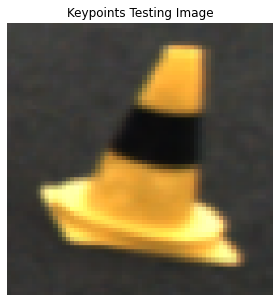

In [13]:
import cv2
%matplotlib inline
import matplotlib.pylab as pt

image = cv2.imread("test_kpt.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Testing Image')

##### Download pretrained weights for inference

In [14]:
# ! wget https://storage.googleapis.com/mit-driverless-open-source/pretrained_kpt.pt
! gsutil cp -p gs://mit-driverless-open-source/pretrained_kpt.pt ./rektnet_weights

Set up config file for inference

In [15]:
model = "rektnet_weights/pretrained_kpt.pt"
img = "test_kpt.png"
img_size = int(80)
output = "outputs/visualization/"
flip = False
rotate = False

##### Prepared Image

In [16]:
output_path = output
model_filepath = model
image_filepath = img

img_name = '_'.join(image_filepath.split('/')[-1].split('.')[0].split('_')[-5:])

image_size = (img_size, img_size)

image = cv2.imread(image_filepath)

image = prep_image(image=image,target_image_size=image_size)
image = (image.transpose((2, 0, 1)) / 255.0)[np.newaxis, :]
image = torch.from_numpy(image).type('torch.FloatTensor')

In [17]:
# Make sure in Google Colab to set it to work on GPU
torch.cuda.is_available()

False

In [19]:
model = KeypointNet()
model.load_state_dict(torch.load(model_filepath, map_location=torch.device('cpu')).get('model'))
model.eval()
output = model(image)
out = np.empty(shape=(0, output[0][0].shape[2]))
for o in output[0][0]:
    chan = np.array(o.cpu().data)
    cmin = chan.min()
    cmax = chan.max()
    chan -= cmin
    chan /= cmax - cmin
    out = np.concatenate((out, chan), axis=0)
cv2.imwrite(output_path + img_name + "_hm.jpg", out * 255)

True

Text(0.5, 1.0, 'Keypoints Detection Result')

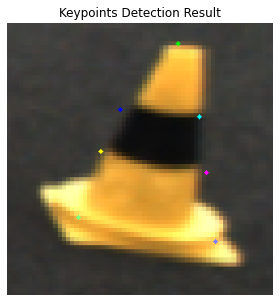

In [20]:
image = cv2.imread(image_filepath)
h, w, _ = image.shape

image = vis_tensor_and_save(image=image, h=h, w=w, tensor_output=output[1][0].cpu().data, image_name=img_name, output_uri=output_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Detection Result')

Test on another image

Text(0.5, 1.0, 'Keypoints Detection Result')

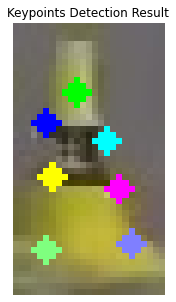

In [31]:
# Remember to upload png image to directory

# Prepared image
image_filepath = "dataset/RektNet_Dataset/vid_2_frame_1708_0.jpg"

img_name = '_'.join(image_filepath.split('/')[-1].split('.')[0].split('_')[-5:])

image_size = (img_size, img_size)

image = cv2.imread(image_filepath)

image = prep_image(image=image,target_image_size=image_size)
image = (image.transpose((2, 0, 1)) / 255.0)[np.newaxis, :]
image = torch.from_numpy(image).type('torch.FloatTensor')
#---------------------------------------------------------#
output = model(image)
out = np.empty(shape=(0, output[0][0].shape[2]))
for o in output[0][0]:
    chan = np.array(o.cpu().data)
    cmin = chan.min()
    cmax = chan.max()
    chan -= cmin
    chan /= cmax - cmin
    out = np.concatenate((out, chan), axis=0)
cv2.imwrite(output_path + img_name + "_hm.jpg", out * 255)
#---------------------------------------------------------#
image = cv2.imread(image_filepath)
h, w, _ = image.shape

image = vis_tensor_and_save(image=image, h=h, w=w, tensor_output=output[1][0].cpu().data, image_name=img_name, output_uri=output_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Detection Result')

## 4. Calculate Distance to Keypoints

In [38]:
from keypoint_tutorial_util import print_kpt_L2_distance

model_filepath = "rektnet_weights/pretrained_kpt.pt"
model = KeypointNet()
model.load_state_dict(torch.load(model_filepath, map_location=torch.device('cpu')).get('model'))
# model.to("cuda")
model.eval()

dataloader = val_dataloader
kpt_keys = KPT_KEYS
study_name = "kpt_dist_trial"
evaluate_mode = True
input_size = int(80)

print_kpt_L2_distance(model, dataloader, kpt_keys, study_name, evaluate_mode, input_size)

Congratulations! You've finished all the content of this tutorial!
Hope you enjoy playing with the our object detection model. If you are interested,  please refer to our paper and GitHub Repo for further details.

## Reference
[1] Kieran Strobel, Sibo Zhu, Raphael Chang and Skanda Koppula.
**Accurate, Low-Latency Visual Perception for Autonomous Racing:Challenges, Mechanisms, and Practical Solutions**. In *IROS* 2020.
[[paper]](https://arxiv.org/abs/2007.13971), [[code]](https://github.com/cv-core/MIT-Driverless-CV-TrainingInfra).